In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA
import statsmodels.api as sm
import pandas as pd
import os
from xgboost.sklearn import XGBRegressor
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics  
from sklearn.model_selection import GridSearchCV , TimeSeriesSplit
import matplotlib.pylab as plt
import pandas as pd


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
# dummy= xr.open_dataset(r"C:\nasa_comp_data_un\oe_fc1_dscovr_s20230930000000_e20230930235959_p20231001022611_pub.nc" )

# dummy = dummy.to_dataframe()

# dummy= dummy.resample('T').mean()

# dummy.reset_index(inplace= True)
# original = pd.DataFrame(columns = dummy.columns)

# directory = "C:\\nasa_comp_data_un"

# for i, filename in enumerate( os.listdir(directory)):
#     if filename.endswith(".nc"):
#         filepath=os.path.join(directory,filename)
#         print(f"opnening file: {filepath}")
#         xr_df= xr.open_dataset(filepath)
#         new_df = xr_df.to_dataframe()
#         new_df = new_df.fillna()
#         new_df= new_df.resample('T').mean()
#         new_df.reset_index(inplace=True)
#         dfs.append(new_df)
#         print(f"finished {i}/2619")

In [ ]:
original = pd.read_csv(r"dataframe_all.csv",parse_dates=["time"])
original.set_index("time",inplace=True)
original.sort_index(inplace=True)

# number of nan rows in each column 

indicies = list(original.columns[0:9])

# data without flags and alpha values that are all NAN
data_nok = original[indicies]
data_nok.head()

# read k-indicies
k_index = pd.read_csv(r"Kpfrom2016.csv" , parse_dates=["time"] , index_col = "time")

data_nok.reset_index(inplace=True)
k_index.reset_index(inplace=True)

mereged =  pd.merge(data_nok , k_index, on='time', how='left')
mereged.set_index("time" , inplace=True)
mereged.drop_duplicates(keep="first",inplace=True)
mereged = create_features(mereged)
del(data_nok)
del(original)
del(k_index)

In [ ]:
 merged = pd.read_csv(r"merged_without_ffill.csv" , parse_dates = ["time"] , index_col="time")

In [ ]:
merged.K= merged.K.ffill()
# mereged.to_csv("merged_ffill.csv")

In [ ]:
# model = sm.tsa.SARIMAX(data_smooth, order=(2,1,1), seasonal_order=(1,0,1,7))
# results = model.fit()
# aic=results.aic
# print('AIC: ',aic)

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
sf = StatsForecast(
    models = [AutoARIMA()],
    freq = 'T',
    df=test_arima.dropna(),
    n_jobs=-1,
)
res= sf.fit()

preds = res.predict(h=60, level=[90])
preds = preds.reset_index().set_index("ds")
preds.drop("unique_id",axis=1, inplace = True)

plt.plot( mereged.loc["2017-01-01 00"]["proton_vx_gsm"].index,mereged.loc["2017-01-01 00"]["proton_vx_gsm"] , preds["AutoARIMA-hi-90"]) 

In [ ]:
clean_data = mereged.loc["2017":"2018"]
clean_data["weekofyear"] =clean_data["weekofyear"].astype(int) 

In [ ]:
clean_data_train
clean_data_train.dropna(inplace=True)

In [ ]:
clean_data["K"] = clean_data["K"].ffill()

In [ ]:
clean_data_train=clean_data.iloc[0:int(len(clean_data)*0.9)]

In [ ]:
def create_lag_features(data, n_lags,col):
    for i in range(1, n_lags+1):
        data_frameb[f'lag_{i}'] = data[col].shift(i)

In [ ]:
corr_map= clean_data_train.corr() 
target = ["proton_vx_gse", "proton_vx_gsm","proton_speed"]
features= [x for x in clean_data_train.columns if x not in target ]

In [ ]:
from sklearn.model_selection import GridSearchCV
import time 
start = time.time()
param_dist = {
    'learning_rate': [0.01, 0.1],
    'max_depth':[5,9],
    'min_child_weight': [5,10],
    'reg_lambda': [ 1e-2, 0.1],
    'reg_alpha': [ 1e-2, 0.1]
}

x_search , y_search = clean_data_train[features].loc["2017-06":"2017-08"], clean_data_train[target].loc["2017-06":"2017-08"]
model = xgb.XGBRegressor(tree_method = "hist", device = "cuda" )
print ("start searhing")
random_search = GridSearchCV(model, param_grid=param_dist, scoring='neg_root_mean_squared_error', cv=5, verbose=5, n_jobs=-1)
print("model fitting...")
random_search.fit(x_search , y_search)
print ("finished searhing")
end = time.time()
print(random_search.best_params_)

In [ ]:
best_params = random_search.best_params_

In [ ]:
random_search.best_score_

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss  = TimeSeriesSplit(n_splits = 6 , test_size= 24*120)
clean_data_train = clean_data_train.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(clean_data_train.dropna()):
    train = clean_data_train.iloc[train_idx]
    test = clean_data_train.iloc[val_idx]


    FEATURES = features
    TARGET = target

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(**best_params, tree_method = "hist", device = "cuda")
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [ ]:
reg = xgb.XGBRegressor(**best_params, tree_method = "hist", device = "cuda")
reg.fit(clean_data_train.dropna()[features],clean_data_train.dropna()[target],
            eval_set=[(clean_data_train.dropna()[features],clean_data_train.dropna()[target])],
            verbose=100 , )

In [ ]:
pd.DataFrame([reg.feature_importances_],columns=reg.feature_names_in_)

In [ ]:
y_pred_best = best_xgb_model.predict()

In [ ]:
x_test = clean_data.loc["2018-10-19 01:30:00":"2018-10-19 02:00:00"][features] 

In [ ]:
y_test = clean_data.loc["2018-10-19 01:30:00":"2018-10-19 02:00:00"][target] 

In [ ]:
y_pred = pd.DataFrame(reg.predict(x_test), index = x_test.index , columns = target)

In [ ]:
def make_stats(df,i,col): 
    return pd.DataFrame({"unique_id":1 , "ds":df.index , "y": df[col]})
    

In [ ]:
reg.save_model("model.json")

In [ ]:
sf = StatsForecast(
    models = [AutoARIMA()],
    freq = 'T',
    df=test_arima.dropna(),
    n_jobs=-1,
)
res= sf.fit()

preds = res.predict(h=60, level=[90])
preds = preds.reset_index().set_index("ds")
preds.drop("unique_id",axis=1, inplace = True)

plt.plot( mereged.loc["2017-01-01 00"]["proton_vx_gsm"].index,mereged.loc["2017-01-01 00"]["proton_vx_gsm"] , preds["AutoARIMA-hi-90"]) 

In [ ]:
sf = StatsForecast(
    models = [AutoARIMA()],
    freq = 'T',
    df=make_stats(clean_data.dropna() , 1 , "proton_vx_gsm"),
    n_jobs=-1,
)

# preds = res.predict(h=60, level=[90])
# preds = preds.reset_index().iset_index("ds")


In [ ]:
res= sf.fit()

In [ ]:
res.get_fitted_param_()

In [ ]:
maskforc = clean_data.any(axis=1)

In [ ]:
for i in clean_data.columns : 
    clean_data[i] = clean_data[i].ffill()


In [ ]:
t = clean_data.apply(lambda x :0  if x.empty else 1 ,axis = 1  )

In [24]:
sf.fitted_[0][0].model_

NameError: name 'sf' is not defined

In [41]:
from statsmodels.tsa.stattools import adfuller
adfuller(clean_data["proton_vx_gse"].dropna())

MemoryError: Unable to allocate 856. MiB for an array with shape (110, 1019443) and data type float64

In [27]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

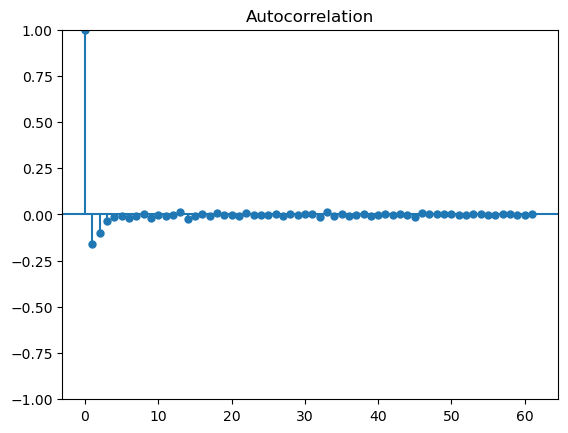

In [34]:
plot_acf(clean_data["proton_vx_gse"], alpha = 0.05 )

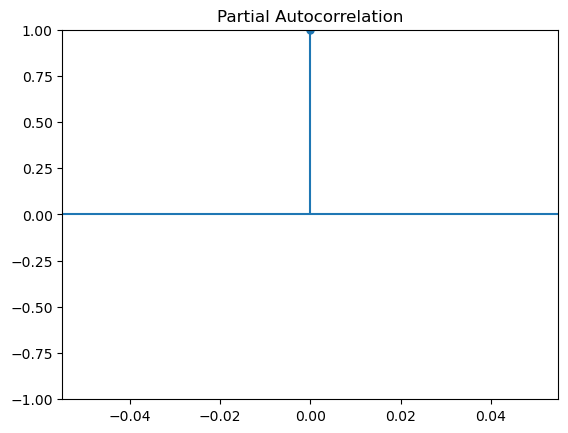

In [36]:
plot_pacf(clean_data["proton_vx_gse"].diff())

In [40]:
import statsmodels.api as sm
model = sm.tsa.ARIMA(clean_data["proton_vx_gse"].dropna(), order=(1,0,1))
results = model.fit()
aic=results.aic
print('AIC: ',aic)

C:\Users\moaaz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\moaaz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC:  7077557.961570825


In [37]:
clean_data.to_csv("clean_data.csv")